# IAU Project - Preprocessing

**Authors:** Peter Mačinec, Lukáš Janík

## Setup and import libraries

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from functools import reduce

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

## Additional functions definitions

Definition of additional functions for visualization of changes in preprocessing:

In [3]:
def data_normalization_compare(before, normalized, removed_outliers):
    """Function to compare data before normalization, after normalization and after removing outliers."""
    plt.rcParams['figure.figsize'] = (10, 4)

    plt.subplot(1, 3, 1)
    before.plot(kind='hist', bins=100)
    plt.title('Before normalization')

    plt.subplot(1, 3, 2)
    normalized.plot(kind='hist', bins=100)
    plt.title('After normalization')

    plt.subplot(1, 3, 3)
    removed_outliers.plot(kind='hist', bins=100)
    plt.title('Removing outliers')

    plt.tight_layout()

def compare_filling(before, aggregation, model):
    """Function to compare data before filling, after filling using aggregation and using model."""
    plt.rcParams['figure.figsize'] = (10, 4)

    plt.subplot(1, 3, 1)
    before.plot(kind='hist', bins=100)
    plt.title('Before filling')

    plt.subplot(1, 3, 2)
    aggregation.plot(kind='hist', bins=100)
    plt.title('After filling using median')

    plt.subplot(1, 3, 3)
    model.plot(kind='hist', bins=100)
    plt.title('After filling using model')

    plt.tight_layout()

## Read the data

Data are divided into two files, personal and other, so we need to read both of them:

In [4]:
# read datasets
df1 = pd.read_csv('data/personal_train.csv', index_col=0)
df2 = pd.read_csv('data/other_train.csv', index_col=0)

## Preprocessing

### Merge datasets

At first, we need to merge both datasets into one. In previous analysis, we found that name and address would be used for merging:

In [5]:
df_train = pd.merge(df1, df2, on=["name", "address"])

In descriptive analysis, we found some duplicates. In second dataset with medical information, there were some duplicates, so we will merge their values and drop duplicated rows.

### Data repairing

We know from a previous analysis that some data need to be repaired. Some columns have one value represented by more strings, another case is that column holds several values that need to be expanded, etc. In this section, data will be repaired at first so missing values would be replaced in next step.

All operations will be done using **Pipelines**, so whole preprocessing process will be reusable.

#### Merge and drop duplicates

As mentioned before, there are some duplicates. Let's check them:

In [6]:
duplicates = df_train[df_train.duplicated(['name', 'address'], keep='first')].sort_values('name')

In [7]:
duplicates.head()

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f
855,Amelia Rodriguez,"087 Gary Port\r\nWest Sarah, KY 66896",77.0,F,1941-03-17,f,NaN,t,f,84.0,...,White|United-States\r\nBachelors -- Widowed|Un...,t,f,SVI,NaN,f,Sales,f,?,f
904,Angela Boyer,"3750 Chen Groves\r\nPamelatown, ME 02894",75.0,F,1942-12-28,NaN,NaN,t,f,92.0,...,White|United-States\r\nHS-grad -- Divorced|Own...,t,f,SVI,9.0,f,Priv-house-serv,f,?,f
1597,Anna Garcia,"71052 Annette Roads\r\nChristinechester, MT 16249",65.0,F,1953-05-06,f,f,f,f,NaN,...,White|United-States\r\nHS-grad -- Never-marrie...,f,f,NaN,9.0,f,Handlers-cleaners,f,?,NaN
2204,Annette Hunt,USNV Lamb\r\nFPO AA 85130,33.0,F,1984-12-08,f,f,f,f,NaN,...,White|United-States\r\nSome-college -- Married...,f,f,NaN,10.0,f,Adm-clerical,f,?,f


We can see there are duplicates with same name and address, but they are even not representing different medical records (measurements are the same). In some attributes, one of duplicates has value and in the other one is this value missing. That means we need to merge those records before droping duplicates.

In [8]:
class MergeRemoveDuplicates(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def merge(self, duplicates):
        return reduce(lambda x,y: x if not pd.isna(x) and not str(x).startswith('?') else y, duplicates)

    def transform(self, df, **transform_params):
        df_copy = df.copy()

        deduplicated = df_copy[df_copy.duplicated(subset=['name', 'address'], keep=False)].groupby(['name','address']).agg(self.merge).reset_index()
        df_copy.drop_duplicates(subset=['name','address'], keep=False, inplace=True)
        df_copy = df_copy.append(deduplicated)
        return df_copy.reset_index()

**Note:** This class will be used for preprocessing in **Pipelines**.

#### Drop rows with missing values in predicted attribute
Rows with missing class label are useless for *supervised learning*. So in our case, these rows will be dropped. Let's check records with missing values for **class** attribute:

In [9]:
df_train[df_train['class'].isnull()][['name', 'class']]

,name,class
362,Frank Gerace,NaN
575,Carol Crum,NaN
1321,Cynthia Schmidtke,NaN
1519,Don Carroll,NaN
1675,Shirley Kiser,NaN
1771,Lila Womack,NaN
1840,Jane Little,NaN


To make this operation reusable, it is better to write custom pipeline with a column as parameter, so every row with a missing value in this column will be dropped.

In [10]:
class DropRowsNanColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df = df[pd.notnull(df[self.column])]
        return df

#### Missing values unifying

In some columns, missing values are represented by *nan*, or also by *'?'* character. Those values need to be unified, so we can fill them later using universal pipeline.

In [11]:
class NanUnifier(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy.loc[df_copy[column].str.strip() == '?', column] = np.NaN
        return df_copy

#### Boolean unifying

A lot of columns that store boolean values, mostly whether was measurement done or not, have inconsistent representation of boolean values (t, t.19, ...). It is better to unify them, because as it is categorical attribute, every reasonable value type should be represented just by one specific value.

In [12]:
class BooleanUnifier(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df_copy[column].map(lambda x: str(x).lower().startswith('t'), na_action='ignore')
        return df_copy

#### Date format unifying

date_of_birth column has values with various date formatting, we'd better unify that.

In [13]:
class DateFormatUnifier(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def fix_date(self, x):
        x = str(x)
        to_return = ''
        x = str(x)
        p_year = re.compile('(^[^-/]+)')
        p_month = re.compile('[-/](.*)[-/]')
        p_day = re.compile('[-/][0-9]*[-/]([0-9]*)')

        year = p_year.findall(x)[0]
        day = p_day.findall(x)[0]
        month = p_month.findall(x)[0]

        swap = False

        if int(day) > 31:
            tmp = day
            day = year
            year = tmp
            swap = True
        if int(month) > 12:
            tmp = month
            month = year
            year = month
            swap = True
        if not swap and len(str(year)) <= 3:
            year = '19' + year

        to_return = str(day) + '/' + str(month) + '/' + str(year)

        return to_return

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        df_copy[self.column] = df_copy[self.column].map(lambda x: self.fix_date(x), na_action='ignore')
        return df_copy

#### Class format unifying

Our class, that is going to be predicted later, contains various representations of the same value. It is better to unify these values:

In [14]:
df_train['class'].unique()

array(['negative.|2860', 'negative.|3022', 'negative.|2061', ...,
       'negative.|2413', 'negative.|1704', 'negative.|1135'], dtype=object)

In [15]:
class ClassUnifier(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['class_status'] = df['class'].str.extract('(^[^.]+)', expand=False).str.strip().str.lower()
        return df

#### Drop useless columns

Some columns will not help us in predicting class of the patient. It is because those column store only one value, as *TBG measured* attribute:

In [16]:
df_train['TBG measured'].unique()

array(['f', nan, 'f.14'], dtype=object)

After unifying boolean values, it will contain only *false* values. It is better to drop this column.

In [17]:
class DropColumn(TransformerMixin):
    def __init__(self, column):
        self.column = column
        
    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df = df.drop([self.column], axis=1)
        return df

#### Expanding columns

In analysis we've found a column storing numerous values that we could expect to be in separate columns. Machine learning algorithms wouldn't be able to work with this column. However, it can hold important information for prediction so we need to expand this column into several separate columns.

In [18]:
class ColumnExpander(TransformerMixin):
    def __init__(self):
        pass

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df['bred'] = df['personal_info'].str.extract('(^[^|]+)', expand=False).str.strip().str.lower()
        df['origin'] = df['personal_info'].str.extract('[|](.*)\r', expand=False).str.strip().str.lower()
        df['study'] = df['personal_info'].str.extract('[\n](.*)--', expand=False).str.strip().str.lower()
        df['status1'] = df['personal_info'].str.extract('--(.*)[|]', expand=False).str.strip().str.lower()
        df['status2'] = df['personal_info'].str.extract('--.*[|](.*)', expand=False).str.strip().str.lower()
        return df

#### Columns data type transformations

Some columns can contain numbers, but are represented by string. In this case, we need to convert those attributes to numerical, so algorithm can treat them as numbers, not categories:

In [19]:
class ColumnToNumber(TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df[self.column] = pd.to_numeric(df[self.column])
        return df

#### Measured values fixing

As our dataset contains medical data as well, some measurement attributes are involved. There are two columns for each measurement - measured (True/False) and measurement values. 
There are several problems with this data, table below displays problem of measurement values being filled, but no boolean value in measured column.

In [20]:
df_train[df_train['T4U measured'].isnull() & ~df_train['T4U'].isnull()][['T4U measured', 'T4U']]

,T4U measured,T4U
156,NaN,0.94
157,NaN,0.94
189,NaN,1.18
353,NaN,1.11
402,NaN,0.73
419,NaN,1.10
855,NaN,0.87
904,NaN,1.03
1411,NaN,0.80
1772,NaN,1.18


In [21]:
class MeasuredValuesFixer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self
    
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            if len(df_copy[df_copy[str(column) + ' measured'].isnull() & ~df_copy[column].isnull()]):
                    df_copy.loc[df_copy[str(column) + ' measured'].isnull() & ~df_copy[column].isnull(), str(column) + ' measured'] = True
            if len(df_copy[df_copy[str(column) +' measured'].isnull() & df_copy[column].isnull()]):
                    df_copy.loc[df_copy[str(column) + ' measured'].isnull() & ~df_copy[column].isnull(), str(column) + ' measured'] = False
        return df_copy

#### Repair data using Pipeline

For data repair, Pipeline will be used. All pipeline custom classes have already been defined in each section of **data repairing**, so we can just use them now:

In [22]:
repair_ppl = Pipeline([
                # unify boolean values
                ('unify_boolean', BooleanUnifier(['query hyperthyroid', 'T4U measured', 'on thyroxine', 'FTI measured', 'lithium', 'TT4 measured',
                                                  'query hypothyroid', 'query on thyroxine', 'tumor', 'T3 measured', 'sick', 'thyroid surgery', 
                                                  'I131 treatment', 'goitre', 'TSH measured', 'on antithyroid medication', 'psych', 'TBG measured',
                                                  'pregnant', 'hypopituitary'])),
                # unify class format
                ('class_unifier', ClassUnifier()),
        
                # unify date format
                ('date_unifier', DateFormatUnifier('date_of_birth')),

                # drop column
                ('drop_TBG_measured', DropColumn('TBG measured')),
                ('drop_TBG', DropColumn('TBG')),
        
                # measured columns fix
                ('fix_measured_values',MeasuredValuesFixer(['T4U', 'FTI', 'TT4', 'TT4','TSH','T3'])),

                # expand column
                ('expand_personal_info', ColumnExpander()),
    
                # unify nan values
                ('nan_unify_FTI', NanUnifier(['FTI', 'sex', 'origin', 'occupation'])),
        
                # transform data type
                ('column_to_number_FTI', ColumnToNumber('FTI')),

                # drop, where are nan values
                ('drop_class', DropRowsNanColumn('class')),
    
                # merge and remove duplicates
                ('rm_duplicates', MergeRemoveDuplicates())
              ])

In [23]:
repaired = repair_ppl.fit_transform(df_train)

##### Data repair overview

**We've fixed**: 
- values of boolean columns which cointained same values just with different labeling:
    - **case of**: 
        - query hyperthyroid, T4U measured, on thyroxine, FTI measured, lithium, TT4 measured, query hypothyroid, query on thyroxine, tumor, T3 measured, sick, thyroid surgery, I131 treatment, goitre, TSH measured, on antithyroid medication, psych, TBG measured, pregnant, hypopituitary

In [24]:
# Before fixing
df_train['FTI measured'].unique()

array(['f', 't', nan, 't.4'], dtype=object)

In [25]:
# After fixing
repaired['FTI measured'].unique()

array([False, True], dtype=object)

- date values in column(s) containing dates as there were various date formats and years written in full or shorten form:
    - **case of:**
        - date_of_birth

In [26]:
# Before fixing
df_train['date_of_birth'][8]

'1983-02-12 00 00 00'

In [27]:
# After fixing
repaired['date_of_birth'][8]

'12/02/1983'

- columns bringing no information as there was a single value (f, ?) by dropping them:
    - **case of:**
        - TBG measured, TBG

In [28]:
# Before fixing
df_train['TBG measured'].head()

0    f
1    f
2    f
3    f
4    f
Name: TBG measured, dtype: object

In [29]:
# Before fixing
df_train['TBG'].head()

0    ?
1    ?
2    ?
3    ?
4    ?
Name: TBG, dtype: object

In [30]:
# After fixing
'TBG' and 'TBG measured' in repaired

False

- columns containing numerous values that were supposed to be in separate columns by extracting them:
    - **case of:**
        - personal_info

In [31]:
# Before fixing
df_train['personal_info'][0]

'White|United-States\r\nHS-grad -- Divorced|Unmarried'

In [32]:
# After fixing
repaired[['bred','origin','study','status1','status2']].head(n=1)

,bred,origin,study,status1,status2
0,white,united-states,hs-grad,divorced,unmarried


- columns that weren't in correct data type by transforming them to the correct one:
    - **case of:**
        - FTI

In [33]:
# Before fixing
type(df_train['FTI'].values[0])

str

In [34]:
# After fixing
type(repaired['FTI'].values[0])

numpy.float64

- columns that had a row with null value by dropping the whole row:
    - **case of:**
        - class

In [35]:
# Before fixing
df_train['class'].isnull().any()

True

In [36]:
# After fixing
repaired['class'].isnull().any()

False

- duplicated rows (name, address) by merging them

In [37]:
# Before fixing
df_train[df_train['name'] == 'Alfred Still']

,name,address,age,sex,date_of_birth,query hyperthyroid,T4U measured,FTI measured,lithium,TT4,...,personal_info,T3 measured,on antithyroid medication,referral source,education-num,psych,occupation,TBG measured,TBG,pregnant
1655,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,NaN,t,t,f,82.0,...,White|United-States\r\nBachelors -- Married-ci...,f,NaN,other,13.0,f,Prof-specialty,NaN,?,f
1656,Alfred Still,"4175 Smith Keys\r\nNew Taylor, NH 39815",57.0,M,1960-11-02,f,t,t,f,82.0,...,NaN,f,f,other,13.0,f,Prof-specialty,f,?,f


In [38]:
# After fixing
repaired[transformed['name'] == 'Alfred Still']

NameError: name 'transformed' is not defined

* 

### Normalize and remove outliers

In a lot of columns, mostly in those storing measurements values, outliers were found. For some algorithms, it is better to remove them or replace with quantiles. Before doing this, values should be normalized.

#### Normalize numerical attributes 

In [39]:
class Normalizer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, df, y=None, **fit_params):
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = np.log(df_copy[column])
        return df_copy

#### Remove outliers

In [40]:
class OutliersRemover(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.quantile_05 = {}
        self.quantile_95 = {}
        
    def replace_outlier(self, x, column):
        if x < self.quantile_05[column]:
            return self.quantile_05[column]
        elif x > self.quantile_95[column]:
            return self.quantile_95[column]
        else:
            return x

    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.quantile_05[column] = df[column].quantile(.05)
            self.quantile_95[column] = df[column].quantile(.95)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df_copy[column].apply(lambda x: self.replace_outlier(x, column))
        return df_copy

In [41]:
normalize_ppl = Pipeline([
                ('norm_T4U', Normalizer(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age']))
              ])
outliers_ppl = Pipeline([
                ('rmout_T4U', OutliersRemover(['T4U', 'T3', 'TSH', 'TT4', 'FTI', 'age']))
              ])

In [42]:
only_normalized = normalize_ppl.fit_transform(repaired)
normalized = outliers_ppl.fit_transform(only_normalized)

##### Data normalization overview

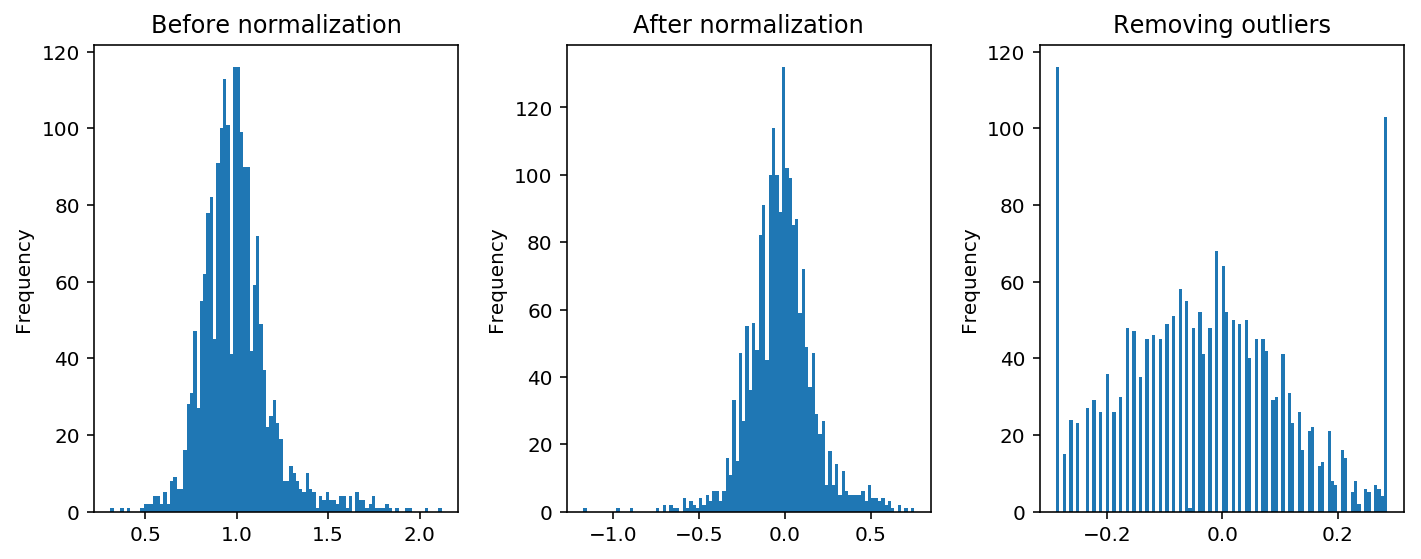

In [43]:
data_normalization_compare(repaired['T4U'], only_normalized['T4U'], normalized['T4U'])

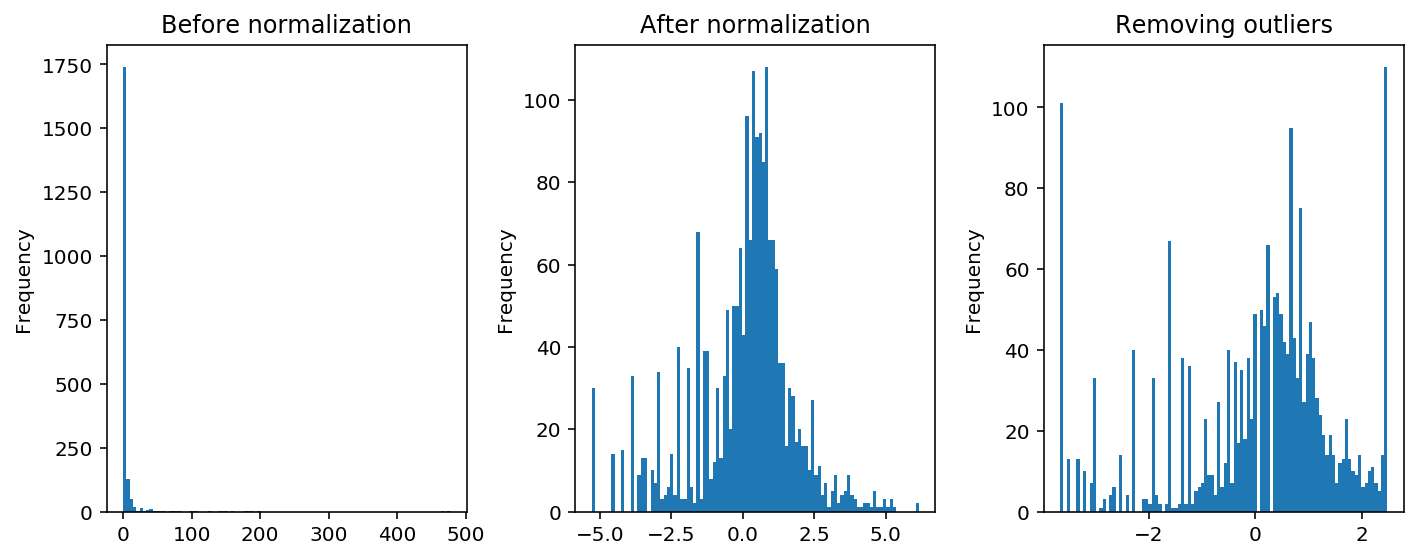

In [44]:
data_normalization_compare(repaired['TSH'], only_normalized['TSH'], normalized['TSH'])

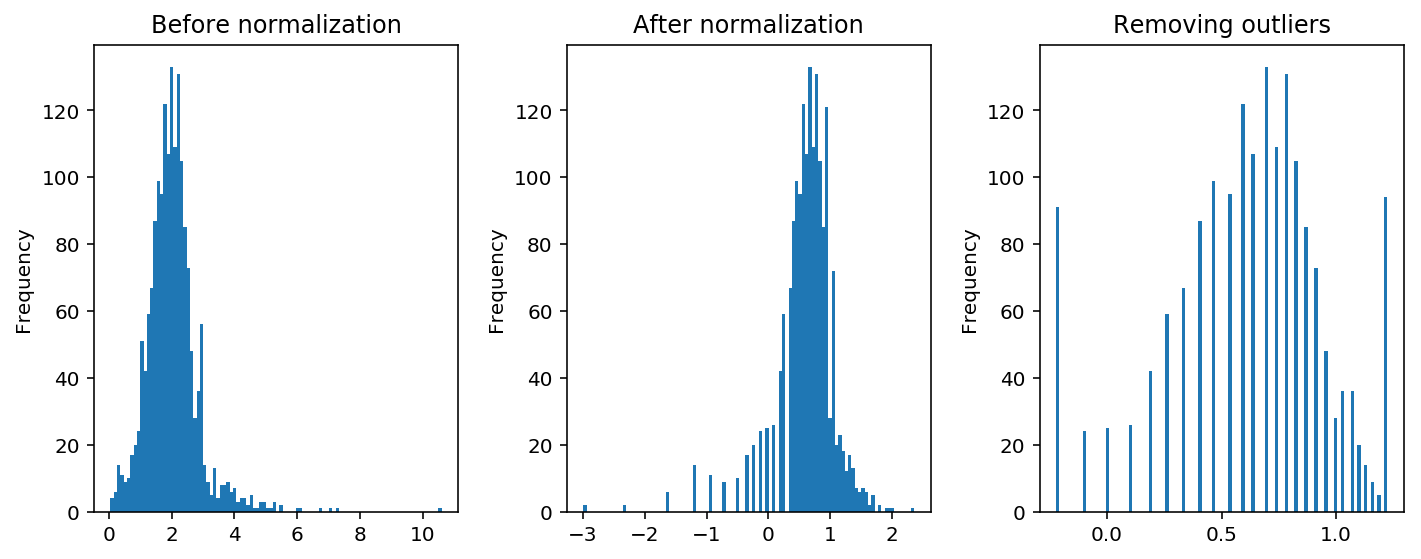

In [45]:
data_normalization_compare(repaired['T3'], only_normalized['T3'], normalized['T3'])

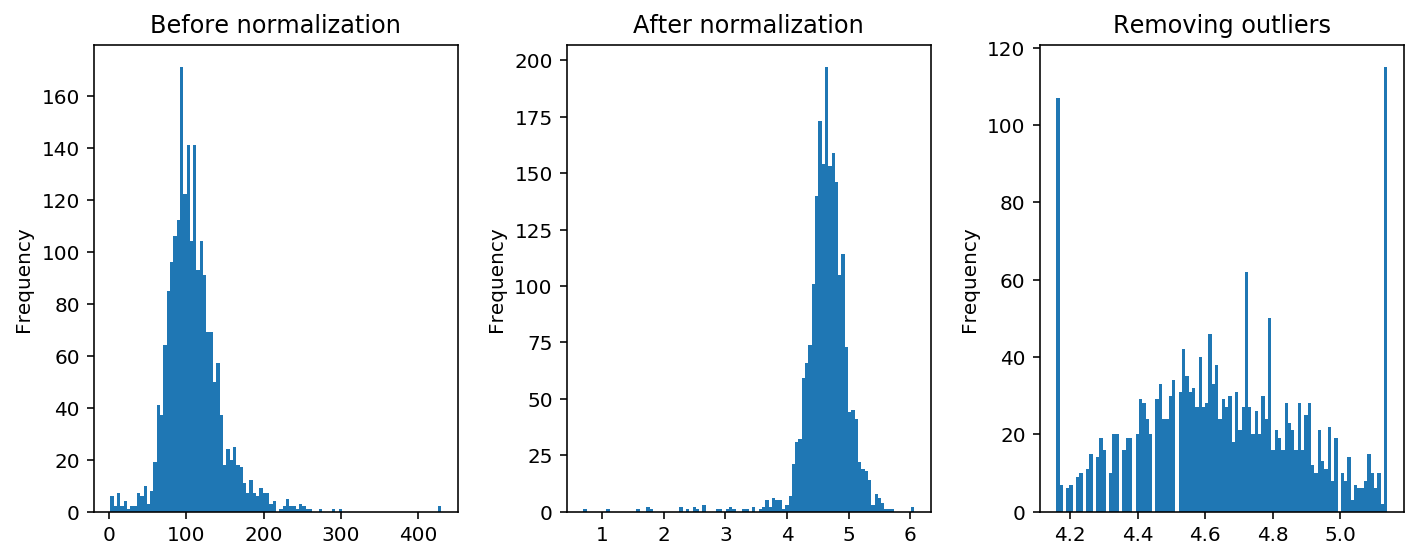

In [46]:
data_normalization_compare(repaired['TT4'], only_normalized['TT4'], normalized['TT4'])

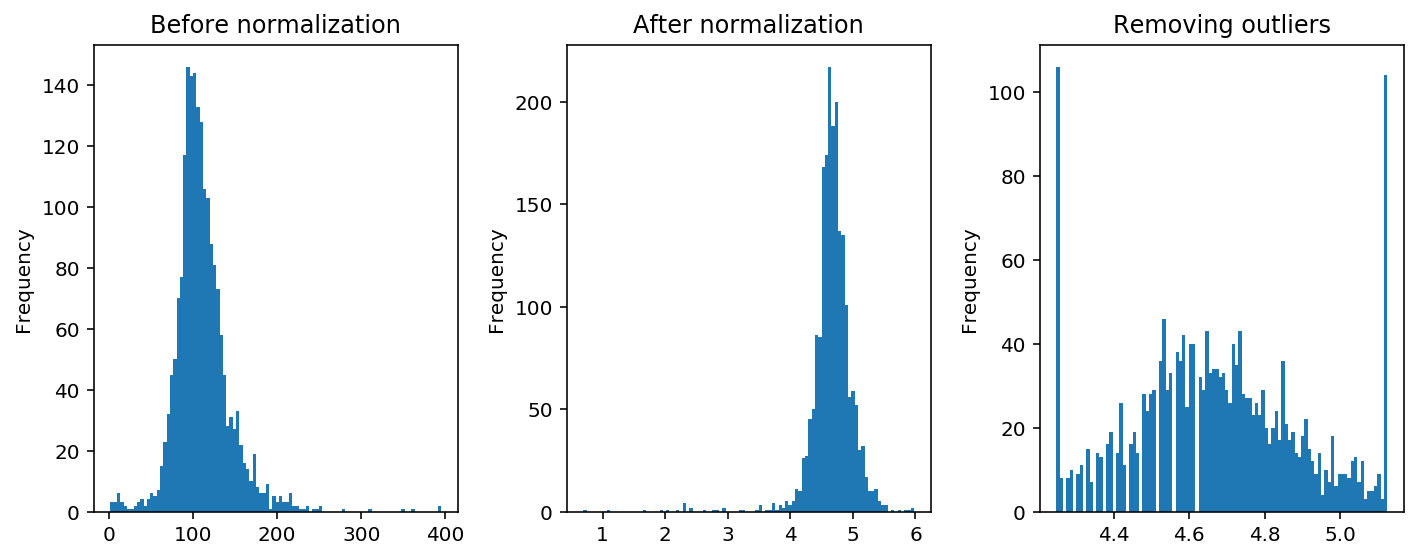

In [47]:
data_normalization_compare(repaired['FTI'], only_normalized['FTI'], normalized['FTI'])

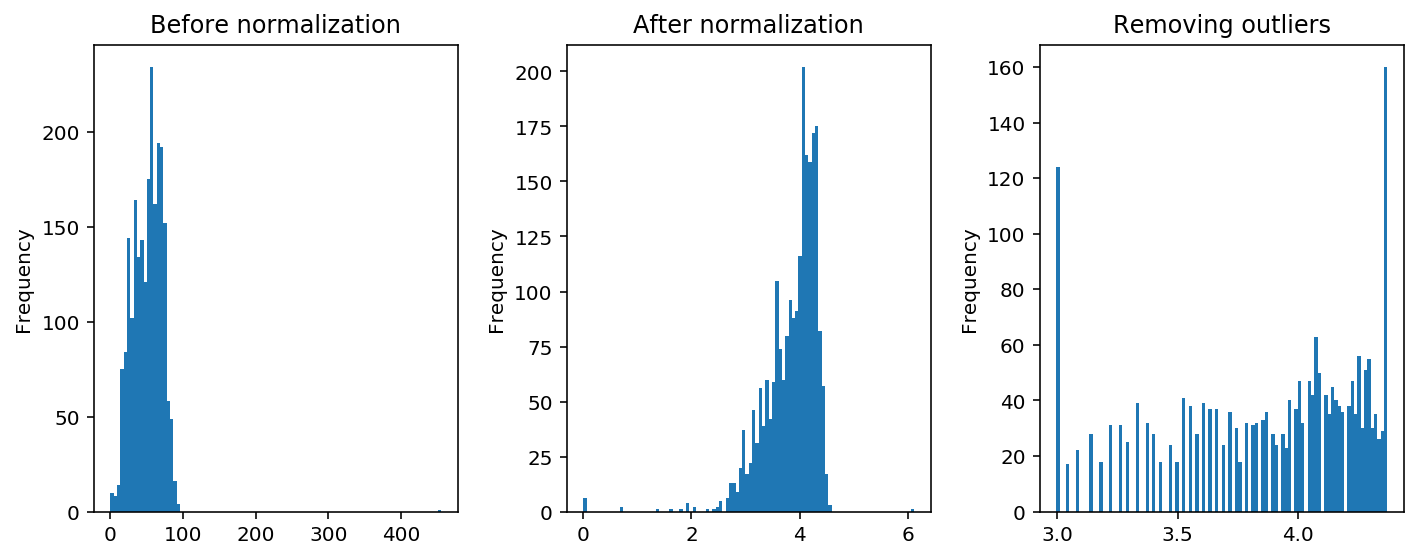

In [48]:
data_normalization_compare(repaired['age'], only_normalized['age'], normalized['age'])

### Filling missing values

Our dataset contains also missing values (NaN), that should be filled before using them in machine learning algorithm. Missing values of numerical, and also categorical attributes should be filled.

In [49]:
from sklearn.linear_model import LinearRegression
from sklearn import model_selection as ms
from sklearn import metrics
from sklearn.model_selection import cross_val_score

#### Fill numerical with median

Numerical attributes can be filled by median, stdev, etc. For this purposes, we have chosen *median*.

At first, we wanted to use *SimpleImputer* in combination with *FeatureUnion* and *FunctionTransformer*, to choose numerical and categorical attributes. There is a problem using that, because *FeatureUnion* and *FunctionTransformer* are creating *numpy* arrays from our DataFrame. There could be one more transformation to dataframe, but we decided to create our own, more simple solution.

In [50]:
class NumMedianFiller(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians = {}
        
    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.medians[column] = df[column].median()
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy[column] = df[column].apply(lambda x: self.medians[column] if pd.isna(x) else x)
        return df_copy

#### Fill numerical with Linear Regression algorithm

In [51]:
class NumModelFiller(TransformerMixin):
    def __init__(self, column, model):
        self.column = column
        self.model = model
        self.medians = {}

    def fit(self, df, y=None, **fit_params):
        # choose all numeric attributes and drop nan values
        self.check = len(df[df[self.column].isnull()]) > 0
        if self.check:
            num_only = df.select_dtypes(include=[np.number]).dropna()

            # create X and y training subsets
            X_train = num_only[num_only.columns.difference([self.column])]
            y_train = num_only[self.column]

            self.columns = X_train.columns.values
            for column in self.columns:
                self.medians[column] = X_train[column].median()
                
            scores = cross_val_score(self.model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
            print("Score for column " + self.column + ": " + str(scores.mean()))
            
            self.model.fit(X_train, y_train)
        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        if self.check:
            # choose only those rows that have missing value in 'column' attribute
            empty_rows = df_copy[df_copy[self.column].isnull()][self.columns]

            for column in self.columns:
                empty_rows.loc[empty_rows[column].isnull(), column] = self.medians[column]

            # create X subset, that will predict
            X_pred = empty_rows[empty_rows.columns.difference([self.column])]

            # predict new values
            y_pred = self.model.predict(X_pred)

            # fill missing values with predicted ones
            df_copy.loc[empty_rows.index, self.column] = y_pred

        return df_copy

#### Fill numerical using Pipeline

In [52]:
normalized.select_dtypes(include=[np.number]).isnull().sum()

index               0
age                 1
TT4               148
T4U               235
capital-loss        0
capital-gain        0
TSH               233
T3                467
fnlwgt              1
FTI               235
hours-per-week      0
education-num     224
dtype: int64

TU ASI POPISAT ZE TEDAVYBERAME LEN TIETO

In [53]:
lr = LinearRegression()
fill_model_ppl = Pipeline([
                ('flr_T4U', NumModelFiller('T4U', lr)),
                ('flr_TT4', NumModelFiller('TT4', lr)),
                ('flr_T3', NumModelFiller('T3', lr)),
                ('flr_TSH', NumModelFiller('TSH', lr)),
                ('flr_FTI', NumModelFiller('FTI', lr))
            ])
fill_median_ppl = Pipeline([
                        ('median_filling', NumMedianFiller(['T4U', 'TT4', 'T3', 'TSH', 'FTI']))
                    ])

In [54]:
df_train.select_dtypes(include=[np.number]).isnull().sum()

age                 1
TT4               162
T4U               246
capital-loss        6
capital-gain       11
TSH               245
T3                489
fnlwgt              8
hours-per-week      9
education-num     235
dtype: int64

In [55]:
filled_model = fill_model_ppl.fit_transform(only_normalized)

Score for column T4U: -3.6072405625536804e-05


Score for column TT4: -3.610897906412379e-05


Score for column T3: -0.13006752848256442


Score for column TSH: -2.3411967340761772


Score for column FTI: -3.367548811834962e-05


In [56]:
filled_median = fill_median_ppl.fit_transform(only_normalized)

##### Compare filling methods using median and model

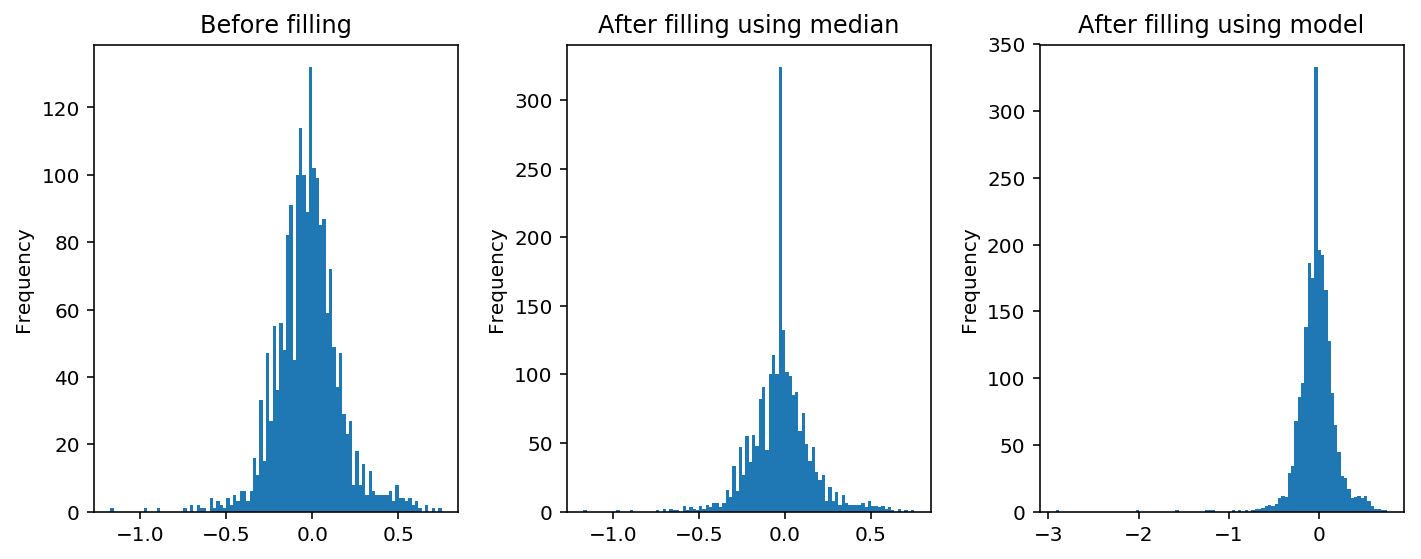

In [57]:
compare_filling(only_normalized['T4U'], filled_median['T4U'], filled_model['T4U'])

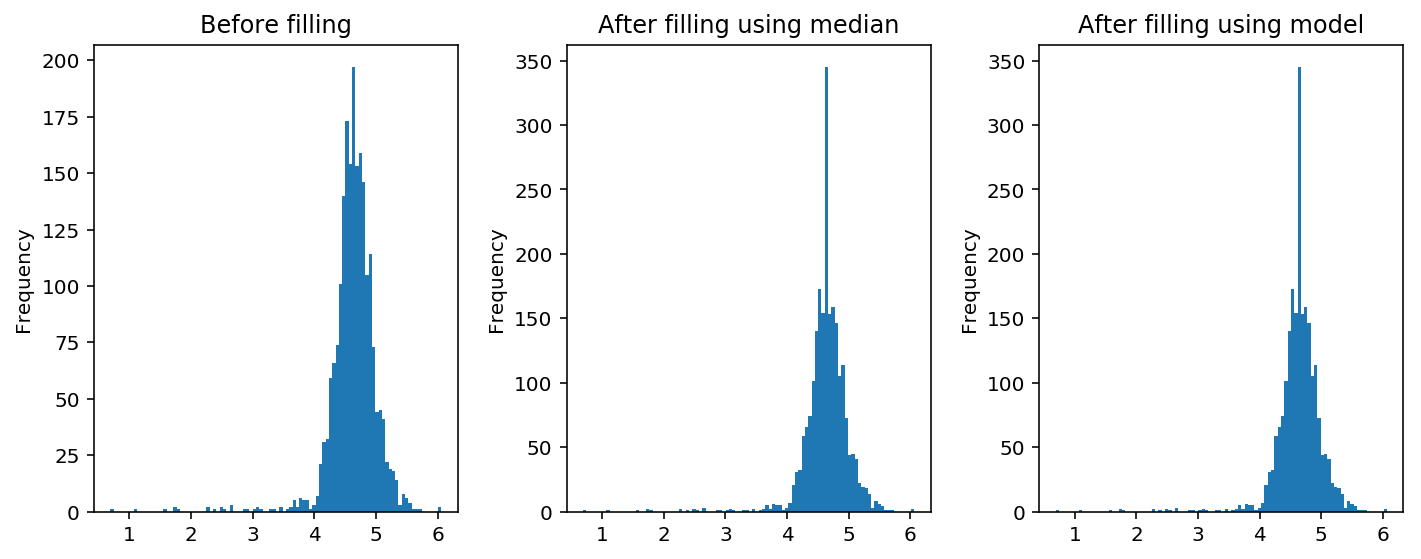

In [58]:
compare_filling(only_normalized['TT4'], filled_median['TT4'], filled_model['TT4'])

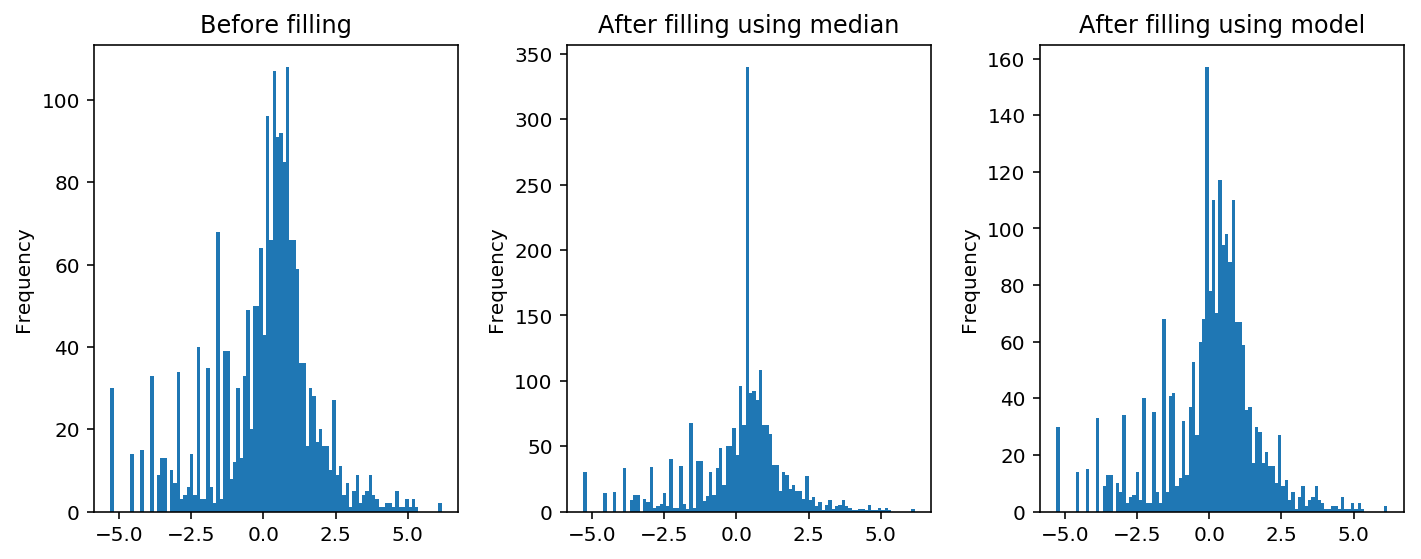

In [59]:
compare_filling(only_normalized['TSH'], filled_median['TSH'], filled_model['TSH'])

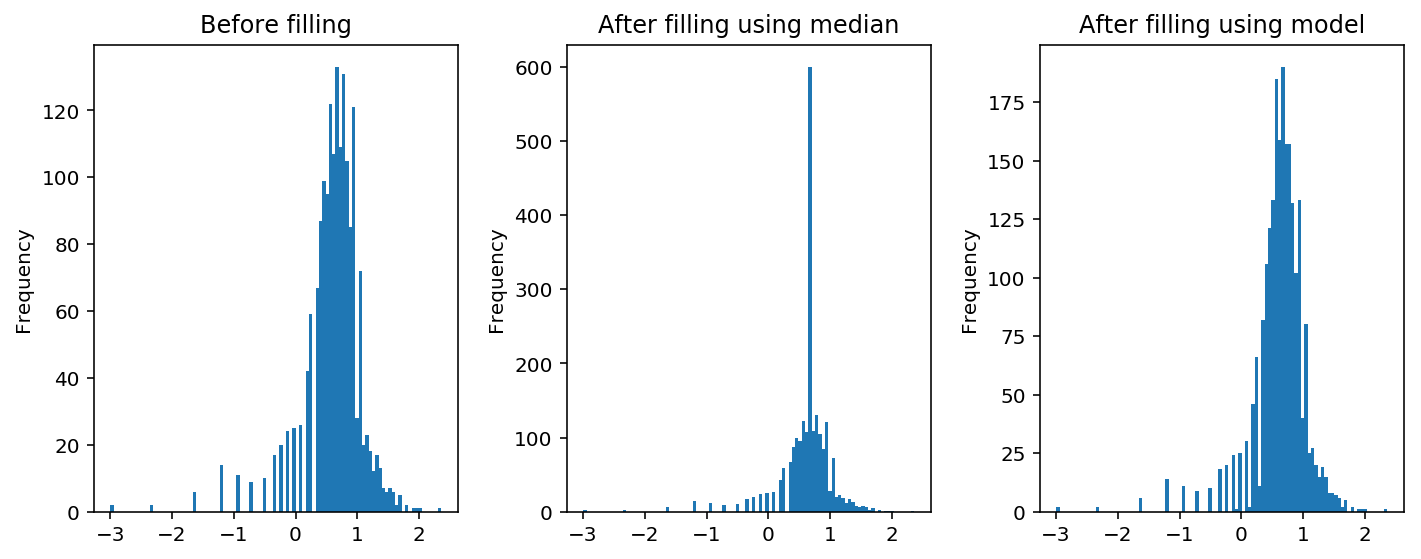

In [60]:
compare_filling(only_normalized['T3'], filled_median['T3'], filled_model['T3'])

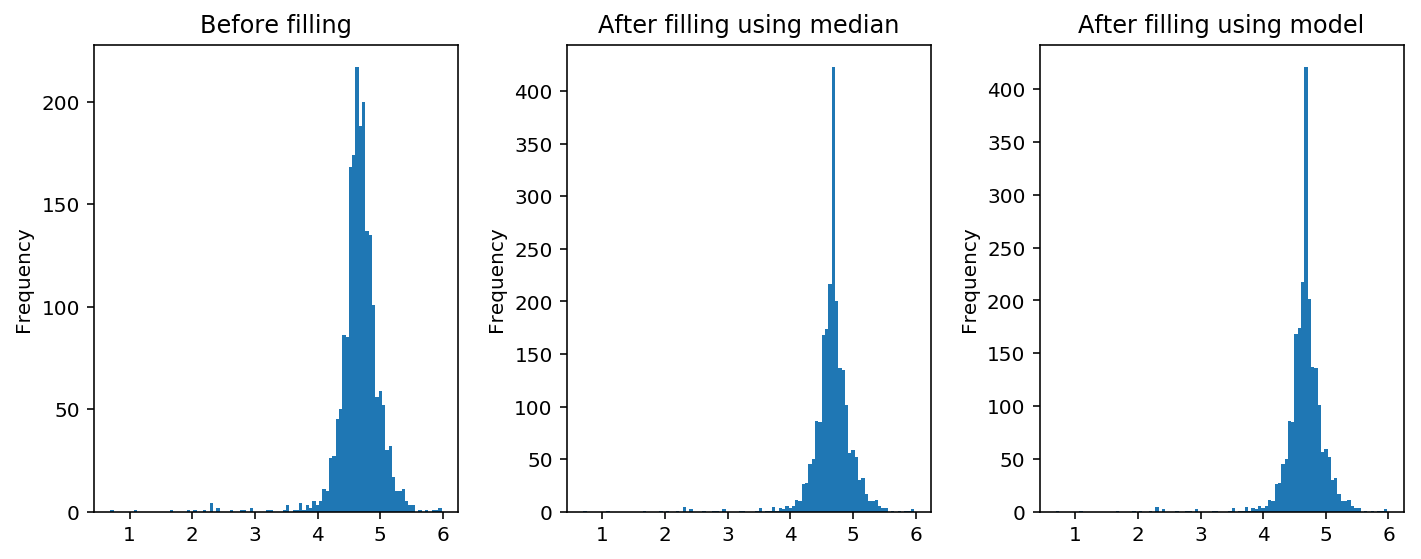

In [61]:
compare_filling(only_normalized['FTI'], filled_median['FTI'], filled_model['FTI'])

- ESTE MOZNO TREBA POPISAT< ZE PRECO SME DALI LEN NORMALIZED A NIE AJ S VYMAZANYMI OUTLIERMI, ZE HORSIE SKORE
- Treba intepretovat napriklad pripad T3, v ktorom doslo pravdepodobne k doplnaniu velkeho mnozstva hodnot

#### Fill categorical with most frequent values

Categorical attributes can be filled by *most frequent* value which we have chosen for this purpose.
The reason for preferring our own way of filling values to imputer is already mentioned above.

In [62]:
class CategoricalMostFrequentFiller(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.most_frequents = {}
        
    def fit(self, df, y=None, **fit_params):
        for column in self.columns:
            self.most_frequents[column] = df[column].value_counts().index[0]
        return self
    
    def transform(self, df, **transform_params):
        df_copy = df.copy()
        for column in self.columns:
            df_copy.loc[df_copy[column].isnull(), column] = self.most_frequents[column]
        return df_copy

#### Fill categorical with Random Forest algorithm

Another approach is to fill missing values using classifier - *Random Forest* to predict the values to be filled.

In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [64]:
class CategoricalModelFiller(TransformerMixin):
    def __init__(self, column, model):
        self.column = column
        self.model = model
        self.medians = {}

    def fit(self, df, y=None, **fit_params):

        # choose all numeric attributes and drop nan values
        self.check = len(df[df[self.column].isnull()]) > 0
        if self.check:
#             num_only = df.select_dtypes(include=[np.number]).dropna()
            num_only_columns = df.select_dtypes(include=[np.number]).columns.values
            # treba pridat column
            num_only = df[num_only_columns].dropna()

            # create X and y training subsets
            X_train = num_only[num_only.columns.difference([self.column])]
            y_train = df[self.column].astype(str)

            self.columns = X_train.columns.values
            for column in self.columns:
                self.medians[column] = X_train[column].median()
            self.model.fit(X_train, y_train)

        return self

    def transform(self, df, **transform_params):
        df_copy = df.copy()
        if self.check:
            # choose only those rows that have missing value in 'column' attribute
            empty_rows = df_copy[df_copy[self.column].isnull()][self.columns]

            for column in self.columns:
                empty_rows.loc[empty_rows[column].isnull(), column] = self.medians[column]

            # create X subset, that will predict
            X_pred = empty_rows[empty_rows.columns.difference([self.column])]

            # predict new values
            y_pred = self.model.predict(X_pred)

            # fill missing values with predicted ones
            df_copy.loc[empty_rows.index, self.column] = y_pred

        return df_copy






#### Fill categorical using Pipeline

In [65]:
filled_mf = Pipeline([
                ('fill_mf', CategoricalMostFrequentFiller(['thyroid surgery', 'goitre', 'pregnant', 'sex', 'on antithyroid medication']))
            ])
filled_model = Pipeline([
                    ('fill_rf', CategoricalModelFiller('sex', KNeighborsClassifier()))
                ])

In [66]:
filled_most_frequent = filled_mf.fit_transform(filled_model)
#filled_knn = filled_model.fit_transform(filled_model)

TypeError: 'Pipeline' object is not subscriptable

In [279]:
filled_model['pregnant'].isnull().sum()

152

In [282]:
filled_most_frequent['pregnant'].isnull().sum()

NameError: name 'filled_most_frequent' is not defined

### Values distribution comparison
Comparison of values distribution - before filling values, after filling by most frequent and filling using Random Forest

In [63]:
def grouped_barplot(df, attribute, groupby, title=None, size=(5, 4), rotation=0):
    """Draw barplot of attribute, grouped by another attribute."""
    plt.rcParams['figure.figsize'] = size
    data = df.groupby(groupby)[attribute].value_counts(normalize=True).rename('percentage').mul(100).reset_index()
    sns.barplot(attribute, 'percentage', hue=groupby, data=data)
    plt.xticks(rotation=rotation)
    plt.title(title)
    plt.legend(loc='upper right')
    plt.rcParams['figure.figsize'] = (5, 4)

Let's take a look at how distribution of values for attribute *pregnant* gets affected by filling (152 missing values).

In [48]:
transformed['pregnant'].value_counts()

False    2057
True       28
Name: pregnant, dtype: int64

In [53]:
filled_by_mf['pregnant'].value_counts()

False    2209
True       28
Name: pregnant, dtype: int64

In [58]:
filled_by_RF['pregnant'].value_counts()

False    2209
True       28
Name: pregnant, dtype: int64

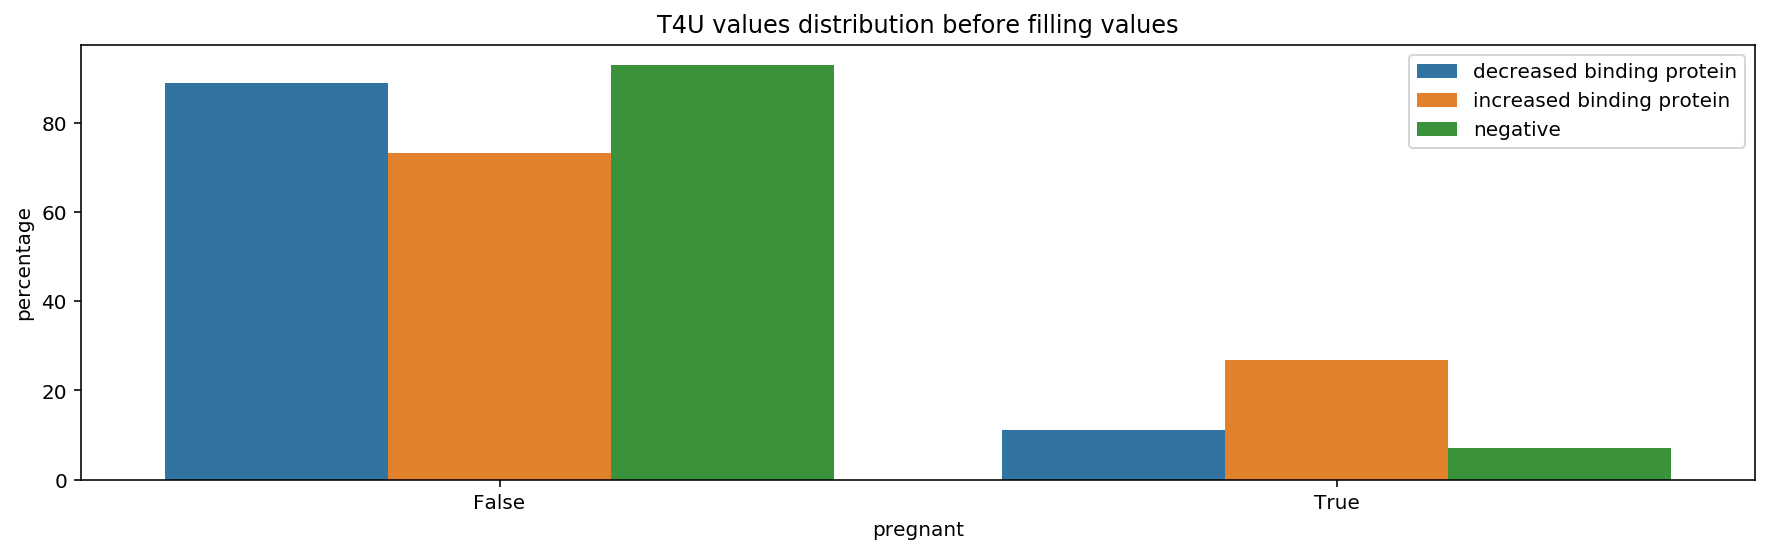

In [65]:
grouped_barplot(filled_by_RF, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

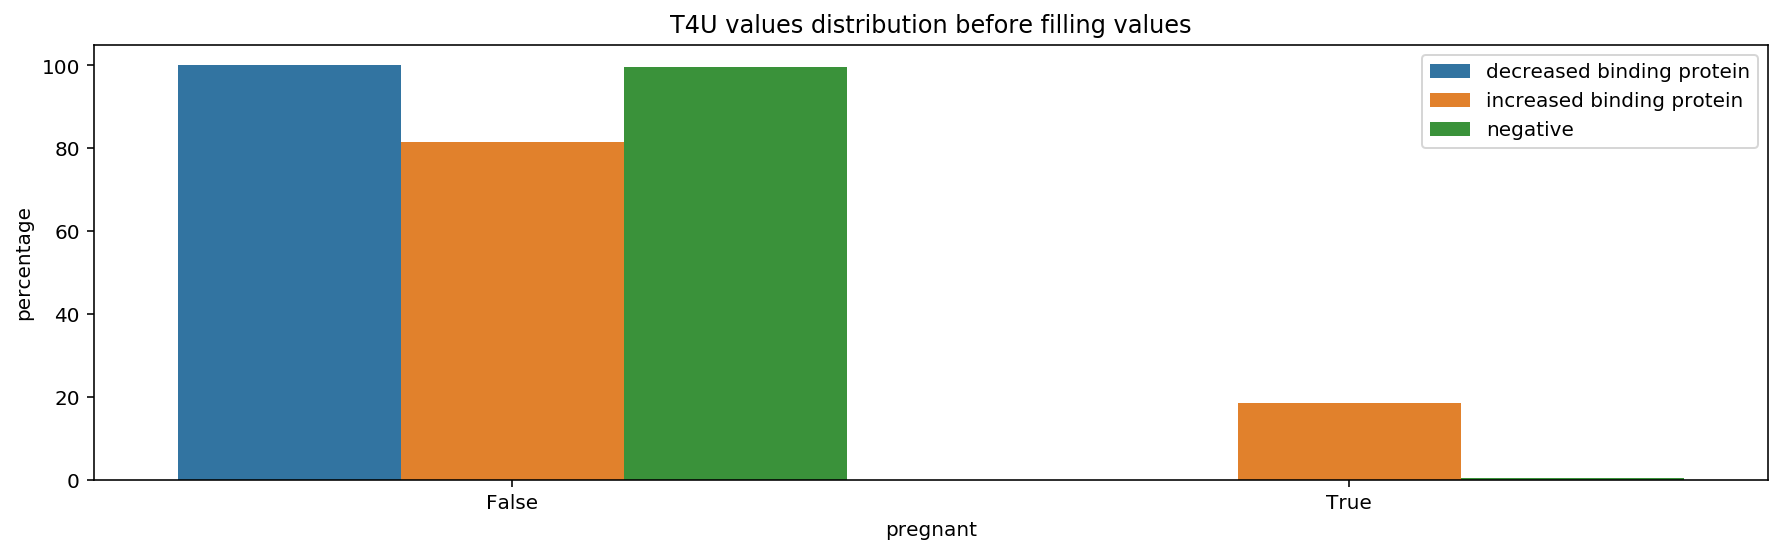

In [66]:
grouped_barplot(filled_by_mf, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

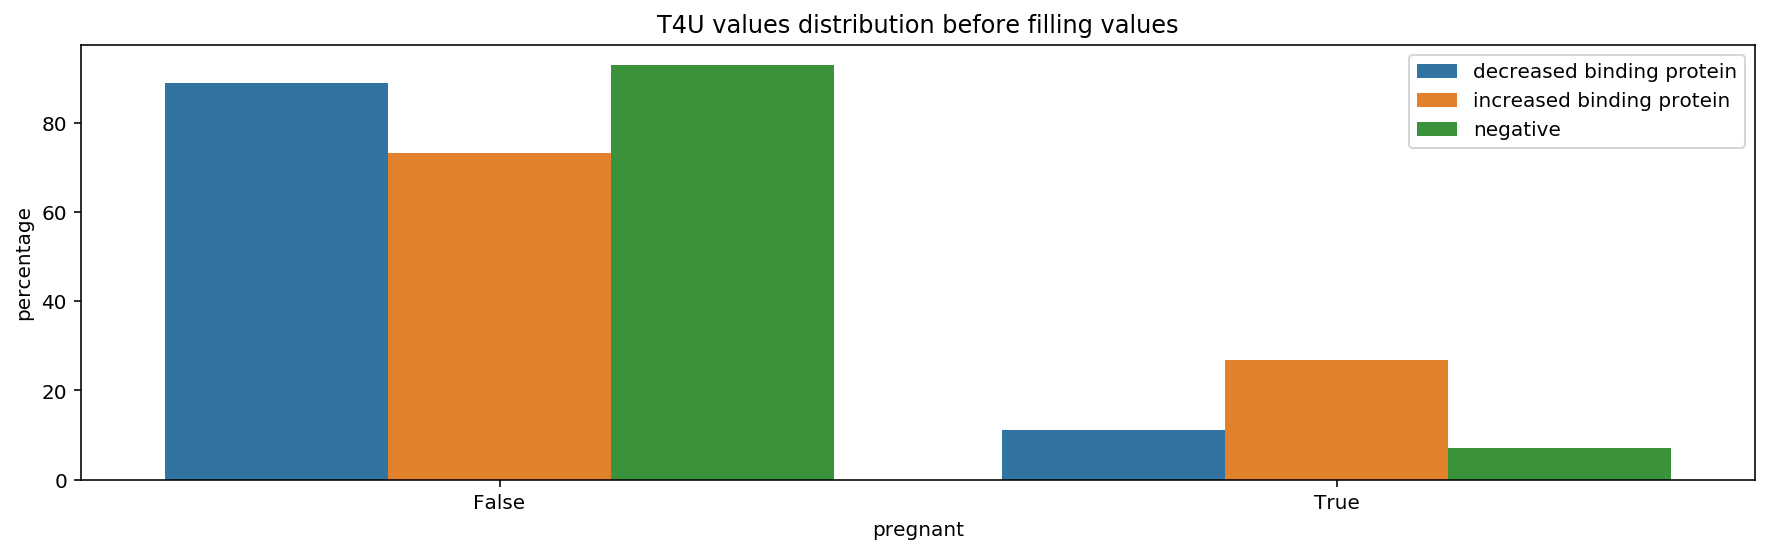

In [64]:
grouped_barplot(filled_by_RF, 'pregnant', 'class_status', 'T4U values distribution before filling values', size=(15,4))

In [44]:
# transformed['origin'].value_counts()
transformed['origin'].isnull().sum()

30

In [43]:
filled_by_RF['origin'].value_counts()

united-states                 2041
mexico                          37
puerto-rico                     13
philippines                     12
dominican-republic               9
haiti                            9
jamaica                          9
germany                          9
el-salvador                      9
canada                           8
cuba                             7
guatemala                        7
japan                            7
italy                            6
poland                           5
india                            5
china                            5
ecuador                          4
nicaragua                        4
peru                             4
england                          4
greece                           3
south                            3
france                           3
taiwan                           3
cambodia                         2
iran                             2
thailand                         2
columbia            

In [55]:
array(['T4U measured', 'FTI measured', 'lithium',
       'TT4', 'T4U', 'query hypothyroid',
       'on thyroxine', 'tumor', 'TSH', 'T3',  'FTI',
       'sick', 'thyroid surgery',
       'I131 treatment', 'TT4 measured', 'class', 'goitre',
       'TSH measured', 'hypopituitary', 'query on thyroxine',
       'T3 measured', 'on antithyroid medication',
       'referral source', 'psych', 'pregnant', 'class_status', 'bred', 'origin', 'study', 'status1',
       'status2'], dtype=object)

array(['index', 'name', 'address', 'age', 'sex', 'date_of_birth',
       'query hyperthyroid', 'T4U measured', 'FTI measured', 'lithium',
       'TT4', 'T4U', 'capital-loss', 'capital-gain', 'query hypothyroid',
       'on thyroxine', 'tumor', 'TSH', 'T3', 'fnlwgt', 'FTI',
       'hours-per-week', 'sick', 'thyroid surgery', 'workclass',
       'I131 treatment', 'TT4 measured', 'class', 'goitre',
       'TSH measured', 'hypopituitary', 'query on thyroxine',
       'personal_info', 'T3 measured', 'on antithyroid medication',
       'referral source', 'education-num', 'psych', 'occupation',
       'pregnant', 'class_status', 'bred', 'origin', 'study', 'status1',
       'status2'], dtype=object)

# TO-DO

* doplnanie hodnot cez KNN
* porovnat doplnanie hodnot modelom a most frequents
* osobitne framy na tie veci porovnania
* pridat popisy
* overit ci sa nepridali dalsi outlieri